# Flat Price Classification

## Raw data

In [183]:
import pandas as pd

df_raw = pd.read_csv('train_data.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SalePrice                  4124 non-null   int64  
 1   YearBuilt                  4124 non-null   int64  
 2   Size(sqf)                  4124 non-null   int64  
 3   Floor                      4124 non-null   int64  
 4   HallwayType                4124 non-null   object 
 5   HeatingType                4124 non-null   object 
 6   AptManageType              4124 non-null   object 
 7   N_Parkinglot(Ground)       4124 non-null   float64
 8   N_Parkinglot(Basement)     4124 non-null   float64
 9   TimeToBusStop              4124 non-null   object 
 10  TimeToSubway               4124 non-null   object 
 11  N_manager                  4124 non-null   float64
 12  N_elevators                4124 non-null   float64
 13  SubwayStation              4124 non-null   objec

In [184]:
df_raw.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


In [185]:
df_raw.isnull().sum()

SalePrice                    0
YearBuilt                    0
Size(sqf)                    0
Floor                        0
HallwayType                  0
HeatingType                  0
AptManageType                0
N_Parkinglot(Ground)         0
N_Parkinglot(Basement)       0
TimeToBusStop                0
TimeToSubway                 0
N_manager                    0
N_elevators                  0
SubwayStation                0
N_FacilitiesInApt            0
N_FacilitiesNearBy(Total)    0
N_SchoolNearBy(Total)        0
dtype: int64

## Data preprocessing

In [186]:
X = df_raw.drop(columns=['SalePrice'])
X.columns = X.columns.str.strip().str.replace(' ', '_')

min_y = df_raw['SalePrice'].min()
max_y = df_raw['SalePrice'].max()

y = pd.cut(df_raw['SalePrice'], bins=[min_y, 100000, 350000, max_y+1], labels=[1, 2, 3], right=False)  

In [187]:
X.select_dtypes(include='object').columns

Index(['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop',
       'TimeToSubway', 'SubwayStation'],
      dtype='object')

In [188]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42,)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f'{X_train.shape=}')
print(f'{X_val.shape=}')
print(f'{X_test.shape=}')

X_train.shape=(3299, 16)
X_val.shape=(412, 16)
X_test.shape=(413, 16)


In [189]:
print("Unique values:\n")
for column in X_train.select_dtypes(include='object').columns:
    print(f'{column}: {X[column].unique().tolist()}')

Unique values:

HallwayType: ['terraced', 'corridor', 'mixed']
HeatingType: ['individual_heating', 'central_heating']
AptManageType: ['management_in_trust', 'self_management']
TimeToBusStop: ['5min~10min', '0~5min', '10min~15min']
TimeToSubway: ['10min~15min', '5min~10min', '0-5min', '15min~20min', 'no_bus_stop_nearby']
SubwayStation: ['Kyungbuk_uni_hospital', 'Daegu', 'Sin-nam', 'Myung-duk', 'Chil-sung-market', 'Bangoge', 'Banwoldang', 'no_subway_nearby']


In [190]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

one_hot_columns = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
ordinal_columns = ['TimeToBusStop', 'TimeToSubway']
scaler_columns = ['YearBuilt', 'Size(sqf)', 'Floor', 'N_FacilitiesInApt', 'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager', 'N_elevators', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
transformed_columns = one_hot_columns + ordinal_columns + scaler_columns

column_transformer = ColumnTransformer([
    ('one_hot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), one_hot_columns),
    ('ordinal', OrdinalEncoder(), ordinal_columns),
    ('scaler', StandardScaler(), scaler_columns)
])



X_train_encoded = column_transformer.fit_transform(X_train[transformed_columns])
X_val_encoded = column_transformer.transform(X_val[transformed_columns])
X_test_encoded = column_transformer.transform(X_test[transformed_columns])

new_column_names = column_transformer.get_feature_names_out(transformed_columns)

X_train = pd.concat([X_train.drop(columns=transformed_columns), pd.DataFrame(X_train_encoded, columns=new_column_names, index=X_train.index)], axis=1)
X_val= pd.concat([X_val.drop(columns=transformed_columns), pd.DataFrame(X_val_encoded, columns=new_column_names, index=X_val.index)], axis=1)
X_test = pd.concat([X_test.drop(columns=transformed_columns), pd.DataFrame(X_test_encoded, columns=new_column_names, index=X_test.index)], axis=1)

In [191]:
X_train.head()

,one_hot__HallwayType_mixed,one_hot__HallwayType_terraced,one_hot__HeatingType_individual_heating,one_hot__AptManageType_self_management,one_hot__SubwayStation_Banwoldang,one_hot__SubwayStation_Chil-sung-market,one_hot__SubwayStation_Daegu,one_hot__SubwayStation_Kyungbuk_uni_hospital,one_hot__SubwayStation_Myung-duk,one_hot__SubwayStation_Sin-nam,...,scaler__YearBuilt,scaler__Size(sqf),scaler__Floor,scaler__N_FacilitiesInApt,scaler__N_Parkinglot(Ground),scaler__N_Parkinglot(Basement),scaler__N_manager,scaler__N_elevators,scaler__N_FacilitiesNearBy(Total),scaler__N_SchoolNearBy(Total)
1327,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.231593,-0.114940,0.537564,0.501520,-0.579926,0.546962,-0.098934,-1.434872,0.914579,0.931745
450,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.460309,1.787145,-1.327655,1.782763,-0.891641,1.703003,2.380703,0.642027,-0.255898,-0.200169
3173,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.231593,-0.561108,-1.194425,0.501520,-0.579926,0.546962,-0.098934,-1.434872,0.914579,0.931745
2503,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.231593,-0.561108,-0.528275,0.501520,-0.579926,0.546962,-0.098934,-1.434872,0.914579,0.931745
1967,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1.941207,0.451250,-1.327655,-0.779724,2.425558,-1.407530,0.520975,2.069896,-0.255898,-1.105701


In [192]:
X_train.shape

(3299, 23)

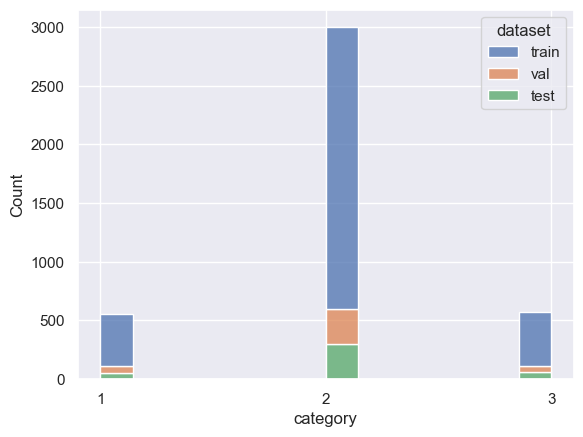

In [ ]:
import seaborn as sns
import numpy as np
sns.set()

y_data = pd.DataFrame({
    "category": np.concatenate([y_train, y_val, y_test]),
    "dataset": ["train"] * len(y_train) + ["val"] * len(y_val) + ["test"] * len(y_test)
})

ax = sns.histplot(y_data, x='category', hue='dataset', multiple="stack")
ax.set_xticks([1, 2, 3])

In [195]:
from sklearn.preprocessing import LabelEncoder
y_transformer = LabelEncoder()

y_train

y_train_transformed = y_transformer.fit_transform(y_train)
y_val_transformed = y_transformer.transform(y_val)
y_test_transformed = y_transformer.transform(y_test)

y_train = pd.Series(y_train_transformed, index=y_train.index, name=y_train.name)
y_val = pd.Series(y_val_transformed, index=y_val.index, name=y_val.name)
y_test = pd.Series(y_test_transformed, index=y_test.index, name=y_test.name)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_dataloader(X, y, batch_size=32, shuffle=False):
    X_tensor = torch.FloatTensor(X.values)
    y_tensor = torch.FloatTensor(y.values)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [ ]:
batch_size = 256

train_dataloader = create_dataloader(X_train, y_train, batch_size=batch_size, shuffle=True)
val_dataloader = create_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataloader = create_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

## Neural Network

In [198]:
import torch.nn as nn

class FlatPriceClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, num_layers, dropout_rate):
        super().__init__()
        layers=[]

        # input layer
        layers.append(nn.Linear(num_inputs, num_hidden))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=dropout_rate))

        # hidden layers
        for _ in range(num_layers-1):
            layers.append(nn.Linear(num_hidden, num_hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_rate))

        # output layer
        layers.append(nn.Linear(num_hidden, num_outputs))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [230]:
from tqdm import tqdm
import torchmetrics

def evaluate(model, dataloader, device, num_classes, verbose=2):
    model.eval()
    metric_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)
    metric_f1 = torchmetrics.classification.F1Score(task='multiclass', num_classes=num_classes, average='macro').to(device)
    metric_auc_roc = torchmetrics.classification.AUROC(task='multiclass', num_classes=num_classes, average='macro').to(device)

    for X, y in tqdm(dataloader, disable=(verbose<2)):
        X, y = X.to(device), y.to(device)

        with torch.inference_mode():
            logits = model(X)
            _, preds = torch.max(logits, dim=1)

            metric_acc(logits, y)
            metric_f1(logits, y)
            metric_auc_roc(logits, y.long())

    return metric_acc.compute(), metric_f1.compute(), metric_auc_roc.compute()

In [ ]:
import torchmetrics.classification
from tqdm import tqdm
import torchmetrics

def train(model, train_dataloader, val_dataloader, loss_module, optimizer, device, num_classes, num_epochs, verbose=2):
    metric_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)
    metric_f1 = torchmetrics.classification.F1Score(task='multiclass', num_classes=num_classes, average='macro').to(device)
    metric_auc_roc = torchmetrics.classification.AUROC(task='multiclass', num_classes=num_classes, average='macro').to(device)

    for epoch in range(num_epochs):
        model.train()

        for X, y in tqdm(train_dataloader, disable=(verbose<2)):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            logits = model(X)

            loss = loss_module(logits, y.long())
            loss.backward()
            optimizer.step()

            _, preds = torch.max(logits, dim=1)
            metric_acc(logits, y)
            metric_f1(logits, y)
            metric_auc_roc(logits, y.long())

        train_accuracy = metric_acc.compute()
        train_f1 = metric_f1.compute()
        train_auc_roc = metric_auc_roc.compute()
        metric_acc.reset()
        metric_f1.reset()
        metric_auc_roc.reset()

        val_accuracy, val_f1, val_auc_roc= evaluate(model, val_dataloader, device, num_classes=num_classes, verbose=verbose)

        if verbose >= 1:
            print(f'Epoch {epoch}:')
            print(f'\t{train_accuracy=:.3f}, {train_f1=:.3f}, {train_auc_roc=:.3f}')
            print(f'\t{val_accuracy=:.3f}, {val_f1=:.3f}, {val_auc_roc=:.3f}')


In [226]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Device: {device}")

Device: cpu


In [232]:
print(f'{X_train.shape=}, {y_train.shape=}, {y_train.unique().tolist()=}')

X_train.shape=(3299, 23), y_train.shape=(3299,), y_train.unique().tolist()=[1, 2, 0]


In [240]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight='balanced',
    classes = y_train.unique(),
    y=y_train 
)

class_weight

array([0.45857659, 2.41154971, 2.47116105])

In [ ]:
classifier = FlatPriceClassifier(num_inputs=23, num_hidden=16, num_outputs=3, num_layers=2, dropout_rate=0.1).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr = 1e-3)
loss_module = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weight))

In [243]:
train(classifier, train_dataloader, val_dataloader, loss_module, optimizer, device, num_classes=3, num_epochs=1000, verbose=1)

Epoch 0:
	train_accuracy=0.342, train_f1=0.299, train_auc_roc=0.494
	val_accuracy=0.315, val_f1=0.277, val_auc_roc=0.497
Epoch 1:
	train_accuracy=0.332, train_f1=0.294, train_auc_roc=0.525
	val_accuracy=0.333, val_f1=0.281, val_auc_roc=0.511
Epoch 2:
	train_accuracy=0.333, train_f1=0.281, train_auc_roc=0.539
	val_accuracy=0.333, val_f1=0.281, val_auc_roc=0.516
Epoch 3:
	train_accuracy=0.333, train_f1=0.281, train_auc_roc=0.539
	val_accuracy=0.333, val_f1=0.281, val_auc_roc=0.518
Epoch 4:
	train_accuracy=0.333, train_f1=0.281, train_auc_roc=0.539
	val_accuracy=0.333, val_f1=0.281, val_auc_roc=0.522
Epoch 5:
	train_accuracy=0.333, train_f1=0.281, train_auc_roc=0.545
	val_accuracy=0.333, val_f1=0.281, val_auc_roc=0.522
Epoch 6:
	train_accuracy=0.333, train_f1=0.281, train_auc_roc=0.565
	val_accuracy=0.333, val_f1=0.281, val_auc_roc=0.533
Epoch 7:
	train_accuracy=0.340, train_f1=0.294, train_auc_roc=0.570
	val_accuracy=0.333, val_f1=0.281, val_auc_roc=0.551
Epoch 8:
	train_accuracy=0.370, 